In [166]:
import numpy as np
import pandas as pd
import math
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, GRU
from keras import regularizers

In [167]:
df = pd.read_csv('./data/weather.csv')
temp_CA = df[df['State'] == 'California'].reset_index()
temp_CA = temp_CA[['Date', 'AverageTemperature']]
temp_CA['Date'] = pd.to_datetime(temp_CA['Date'])
temp_CA['AverageTemperature'] = pd.to_numeric(
    temp_CA['AverageTemperature'], errors='coerce')
temp_CA = temp_CA.dropna(subset=['AverageTemperature'])
temp_CA.sort_values('Date', inplace=True, ascending=True)
temp_CA = temp_CA.reset_index(drop=True)
temp_CA = temp_CA[temp_CA["Date"]>="1980-01-01"].reset_index(drop=True)

In [168]:
def Matrix_X_Y(ts: np.array, lag=1, n_ahead=1, target_index=0) -> tuple:
    # Extracting the number of features that are passed from the array
    n_features = ts.shape[1]

    # Creating placeholder lists
    X, Y = [], []

    if len(ts) - lag <= 0:
        X.append(ts)
    else:
        for i in range(len(ts) - lag - n_ahead):
            Y.append(ts[(i + lag):(i + lag + n_ahead), target_index])
            X.append(ts[i:(i + lag)])

    X, Y = np.array(X), np.array(Y)

    # Reshaping the X array to an RNN input shape
    X = np.reshape(X, (X.shape[0], lag, n_features))

    return X, Y


print(temp_CA.head())
print(temp_CA.shape)

ts = temp_CA[['AverageTemperature']].values
# print(ts)
print(ts.shape)

        Date  AverageTemperature
0 1980-01-01                45.9
1 1980-02-01                48.8
2 1980-03-01                47.3
3 1980-04-01                54.5
4 1980-05-01                58.2
(504, 2)
(504, 1)


In [169]:
nrows = ts.shape[0]
test_percent = 0.1
# Spliting into train and test sets
train = ts[0:int(nrows * (1 - test_percent))]
test = ts[int(nrows * (1 - test_percent)):]

# Scaling the data
train_mean = train.mean()
train_std = train.std()
train = (train - train_mean) / train_std
test = (test - train_mean) / train_std

# Creating the final scaled frame
ts_s = np.concatenate([train, test])

lag = 12
ahead = 3

# Creating the X and Y for training
X, Y = Matrix_X_Y(ts_s, lag=lag, n_ahead=ahead)

Xtrain = X[0:int(X.shape[0] * (1 - test_percent))]
Ytrain = Y[0:int(X.shape[0] * (1 - test_percent))]

Xval = X[int(X.shape[0] * (1 - test_percent)):]
Yval = Y[int(X.shape[0] * (1 - test_percent)):]


def plot_model(history, model_title, filename):
    print('History', history.history)
    loss = history.history['loss']
    epochs = range(1, len(loss) + 1)
    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.title(f'Training loss ({model_title})')
    plt.legend()
    plt.savefig(f'./graph/deep_CA/{filename}')


def print_error(trainY, testY, train_predict, test_predict):
    # Error of predictions
    train_rmse = math.sqrt(mean_squared_error(
        trainY[:, 0], train_predict[:, 0]))
    test_rmse = math.sqrt(mean_squared_error(testY[:, 0], test_predict[:, 0]))
    # Print RMSE
    print('Train RMSE: %.3f RMSE' % (train_rmse))
    print('Test RMSE: %.3f RMSE' % (test_rmse))
    return train_rmse, test_rmse


def create_RNN(hidden_units, dense_units, input_shape, activation, kernel_regularizer=None):
    model = Sequential()
    # Create a simple neural network layer
    model.add(SimpleRNN(hidden_units, input_shape=input_shape,
              activation=activation[0]))
    # Add a dense layer 
    model.add(Dense(units=dense_units,
              activation=activation[1],
              kernel_regularizer=kernel_regularizer))
    # Compile the model and optimize on MSE
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model


# Create a LSTM Neural Network
def create_LSTM(hidden_units, dense_units, input_shape, activation, kernel_regularizer=None):
    model = Sequential()
    # Create a simple long short term memory neural network
    model.add(LSTM(hidden_units,
              activation=activation[0], input_shape=input_shape))
    # Add a dense layer (only one, more layers would make it a deep neural net)
    model.add(Dense(units=dense_units,
              activation=activation[1], kernel_regularizer=kernel_regularizer))
    # Compile the model and optimize on mean squared error
    model.compile(optimizer="RMSprop", loss='mae')
    return model


# Create a GRU Neural Network
def create_GRU(hidden_units, dense_units, input_shape, activation, kernel_regularizer=None):
    model = Sequential()
    # Create a simple GRU neural network layer
    model.add(GRU(hidden_units, input_shape=input_shape,
              activation=activation[0]))
    # Add a dense layer (only one, more layers would make it a deep neural net)
    model.add(Dense(units=dense_units,
              activation=activation[1], kernel_regularizer=kernel_regularizer))
    # Compile the model and optimize on MSE
    model.compile(loss='mean_squared_error', optimizer='sgd')
    return model

Epoch 1/20
440/440 - 3s - loss: 1.0158 - 3s/epoch - 6ms/step
Epoch 2/20
440/440 - 1s - loss: 0.5722 - 1s/epoch - 3ms/step
Epoch 3/20
440/440 - 1s - loss: 0.4163 - 1s/epoch - 3ms/step
Epoch 4/20
440/440 - 1s - loss: 0.3536 - 1s/epoch - 3ms/step
Epoch 5/20
440/440 - 1s - loss: 0.3146 - 1s/epoch - 3ms/step
Epoch 6/20
440/440 - 1s - loss: 0.2926 - 1s/epoch - 3ms/step
Epoch 7/20
440/440 - 2s - loss: 0.2811 - 2s/epoch - 4ms/step
Epoch 8/20
440/440 - 1s - loss: 0.2745 - 1s/epoch - 3ms/step
Epoch 9/20
440/440 - 1s - loss: 0.2708 - 1s/epoch - 3ms/step
Epoch 10/20
440/440 - 1s - loss: 0.2675 - 1s/epoch - 3ms/step
Epoch 11/20
440/440 - 1s - loss: 0.2658 - 1s/epoch - 3ms/step
Epoch 12/20
440/440 - 1s - loss: 0.2642 - 1s/epoch - 3ms/step
Epoch 13/20
440/440 - 1s - loss: 0.2622 - 1s/epoch - 3ms/step
Epoch 14/20
440/440 - 1s - loss: 0.2617 - 1s/epoch - 3ms/step
Epoch 15/20
440/440 - 2s - loss: 0.2607 - 2s/epoch - 4ms/step
Epoch 16/20
440/440 - 1s - loss: 0.2603 - 1s/epoch - 3ms/step
Epoch 17/20
440/4

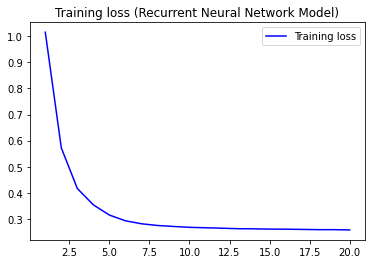

In [170]:
# Create a recurrent neural network
model = create_RNN(hidden_units=3, dense_units=1, input_shape=(lag, Xtrain.shape[-1]),
                   activation=['tanh', 'tanh'])
history = model.fit(Xtrain, Ytrain, epochs=20, batch_size=1, verbose=2)
plot_model(history, 'Recurrent Neural Network Model', 'rnn_model.png')

yhat_d = [x[0] for x in model.predict(Xval)]
y = [y[0] for y in Yval]

train_predict = model.predict(Xtrain)
test_predict = model.predict(Xval)

# Print error
train_rmse, test_rmse = print_error(Ytrain, Yval, train_predict, test_predict)
rmse_table = {
    'model': ['Recurrent Neural Network'],
    'training_rmse': [train_rmse],
    'testing_rmse': [test_rmse]
}

Epoch 1/20
440/440 - 3s - loss: 0.7487 - 3s/epoch - 6ms/step
Epoch 2/20
440/440 - 1s - loss: 0.4890 - 1s/epoch - 3ms/step
Epoch 3/20
440/440 - 1s - loss: 0.3339 - 1s/epoch - 3ms/step
Epoch 4/20
440/440 - 1s - loss: 0.2971 - 1s/epoch - 3ms/step
Epoch 5/20
440/440 - 1s - loss: 0.2831 - 1s/epoch - 3ms/step
Epoch 6/20
440/440 - 1s - loss: 0.2764 - 1s/epoch - 3ms/step
Epoch 7/20
440/440 - 1s - loss: 0.2728 - 1s/epoch - 3ms/step
Epoch 8/20
440/440 - 1s - loss: 0.2711 - 1s/epoch - 3ms/step
Epoch 9/20
440/440 - 1s - loss: 0.2693 - 1s/epoch - 3ms/step
Epoch 10/20
440/440 - 1s - loss: 0.2675 - 1s/epoch - 3ms/step
Epoch 11/20
440/440 - 1s - loss: 0.2661 - 1s/epoch - 3ms/step
Epoch 12/20
440/440 - 1s - loss: 0.2657 - 1s/epoch - 3ms/step
Epoch 13/20
440/440 - 1s - loss: 0.2640 - 1s/epoch - 3ms/step
Epoch 14/20
440/440 - 1s - loss: 0.2644 - 1s/epoch - 3ms/step
Epoch 15/20
440/440 - 1s - loss: 0.2638 - 1s/epoch - 3ms/step
Epoch 16/20
440/440 - 1s - loss: 0.2623 - 1s/epoch - 3ms/step
Epoch 17/20
440/4

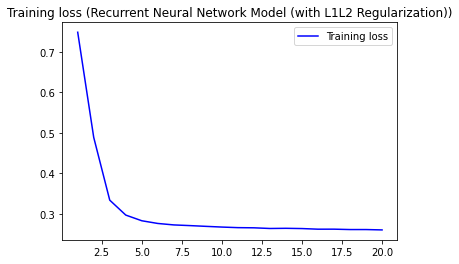

In [171]:
# Create a recurrent neural network with regularization
model = create_RNN(hidden_units=3, dense_units=1, input_shape=(lag, Xtrain.shape[-1]),
                   activation=['tanh', 'tanh'], kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4))
history = model.fit(Xtrain, Ytrain, epochs=20, batch_size=1, verbose=2)
plot_model(history, 'Recurrent Neural Network Model (with L1L2 Regularization)',
           'rnn_reg_model.png')

yhat_d_reg = [x[0] for x in model.predict(Xval)]

train_predict = model.predict(Xtrain)
test_predict = model.predict(Xval)

# Print error
train_rmse, test_rmse = print_error(Ytrain, Yval, train_predict, test_predict)
rmse_table['model'].append(
    'Recurrent Neural Network (with L1L2 Regularization)')
rmse_table['training_rmse'].append(train_rmse)
rmse_table['testing_rmse'].append(test_rmse)

Epoch 1/20
440/440 - 4s - loss: 1.0082 - 4s/epoch - 9ms/step
Epoch 2/20
440/440 - 2s - loss: 1.0057 - 2s/epoch - 5ms/step
Epoch 3/20
440/440 - 2s - loss: 1.0057 - 2s/epoch - 4ms/step
Epoch 4/20
440/440 - 2s - loss: 1.0057 - 2s/epoch - 4ms/step
Epoch 5/20
440/440 - 2s - loss: 1.0057 - 2s/epoch - 4ms/step
Epoch 6/20
440/440 - 2s - loss: 1.0057 - 2s/epoch - 4ms/step
Epoch 7/20
440/440 - 2s - loss: 1.0057 - 2s/epoch - 4ms/step
Epoch 8/20
440/440 - 2s - loss: 1.0057 - 2s/epoch - 4ms/step
Epoch 9/20
440/440 - 2s - loss: 1.0057 - 2s/epoch - 4ms/step
Epoch 10/20
440/440 - 2s - loss: 1.0057 - 2s/epoch - 4ms/step
Epoch 11/20
440/440 - 2s - loss: 1.0057 - 2s/epoch - 4ms/step
Epoch 12/20
440/440 - 2s - loss: 1.0057 - 2s/epoch - 4ms/step
Epoch 13/20
440/440 - 2s - loss: 1.0057 - 2s/epoch - 5ms/step
Epoch 14/20
440/440 - 2s - loss: 1.0057 - 2s/epoch - 4ms/step
Epoch 15/20
440/440 - 2s - loss: 1.0057 - 2s/epoch - 4ms/step
Epoch 16/20
440/440 - 2s - loss: 1.0057 - 2s/epoch - 4ms/step
Epoch 17/20
440/4

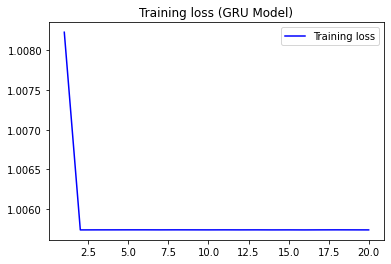

In [172]:
# Training and evaluating a GRU-based model
model = create_GRU(hidden_units=3, dense_units=1, input_shape=(lag, Xtrain.shape[-1]),
                   activation=['tanh', 'relu'])
history = model.fit(Xtrain, Ytrain, epochs=20, batch_size=1, verbose=2)
plot_model(history, 'GRU Model', 'gru_model.png')

yhat_gru = [x[0] for x in model.predict(Xval)]

train_predict = model.predict(Xtrain)
test_predict = model.predict(Xval)

# Print error
train_rmse, test_rmse = print_error(Ytrain, Yval, train_predict, test_predict)
rmse_table['model'].append('GRU Neural Network')
rmse_table['training_rmse'].append(train_rmse)
rmse_table['testing_rmse'].append(test_rmse)

Epoch 1/20
440/440 - 4s - loss: 0.9387 - 4s/epoch - 10ms/step
Epoch 2/20
440/440 - 2s - loss: 0.7072 - 2s/epoch - 4ms/step
Epoch 3/20
440/440 - 2s - loss: 0.6172 - 2s/epoch - 4ms/step
Epoch 4/20
440/440 - 2s - loss: 0.6037 - 2s/epoch - 4ms/step
Epoch 5/20
440/440 - 2s - loss: 0.6019 - 2s/epoch - 5ms/step
Epoch 6/20
440/440 - 2s - loss: 0.6019 - 2s/epoch - 4ms/step
Epoch 7/20
440/440 - 2s - loss: 0.6015 - 2s/epoch - 4ms/step
Epoch 8/20
440/440 - 2s - loss: 0.6014 - 2s/epoch - 4ms/step
Epoch 9/20
440/440 - 2s - loss: 0.6008 - 2s/epoch - 5ms/step
Epoch 10/20
440/440 - 2s - loss: 0.6010 - 2s/epoch - 4ms/step
Epoch 11/20
440/440 - 2s - loss: 0.6005 - 2s/epoch - 4ms/step
Epoch 12/20
440/440 - 2s - loss: 0.6007 - 2s/epoch - 5ms/step
Epoch 13/20
440/440 - 2s - loss: 0.6002 - 2s/epoch - 4ms/step
Epoch 14/20
440/440 - 2s - loss: 0.6003 - 2s/epoch - 4ms/step
Epoch 15/20
440/440 - 2s - loss: 0.6005 - 2s/epoch - 5ms/step
Epoch 16/20
440/440 - 3s - loss: 0.6004 - 3s/epoch - 6ms/step
Epoch 17/20
440/

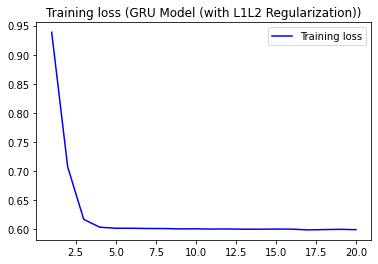

In [173]:
# Training and evaluating a GRU-based model with regularization
model = create_GRU(hidden_units=3, dense_units=1, input_shape=(lag, Xtrain.shape[-1]),
                   activation=['tanh', 'relu'], kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4))
history = model.fit(Xtrain, Ytrain, epochs=20, batch_size=1, verbose=2)
plot_model(history, 'GRU Model (with L1L2 Regularization)', 'gru_reg_model.png')

yhat_gru_reg = [x[0] for x in model.predict(Xval)]

train_predict = model.predict(Xtrain)
test_predict = model.predict(Xval)

# Print error
train_rmse, test_rmse = print_error(Ytrain, Yval, train_predict, test_predict)
rmse_table['model'].append('GRU Neural Network (with L1L2 Regularization)')
rmse_table['training_rmse'].append(train_rmse)
rmse_table['testing_rmse'].append(test_rmse)

Epoch 1/20
440/440 - 5s - loss: 0.8105 - 5s/epoch - 11ms/step
Epoch 2/20
440/440 - 2s - loss: 0.6420 - 2s/epoch - 4ms/step
Epoch 3/20
440/440 - 2s - loss: 0.5039 - 2s/epoch - 4ms/step
Epoch 4/20
440/440 - 2s - loss: 0.4377 - 2s/epoch - 4ms/step
Epoch 5/20
440/440 - 2s - loss: 0.4184 - 2s/epoch - 4ms/step
Epoch 6/20
440/440 - 3s - loss: 0.4093 - 3s/epoch - 6ms/step
Epoch 7/20
440/440 - 2s - loss: 0.4041 - 2s/epoch - 5ms/step
Epoch 8/20
440/440 - 2s - loss: 0.3983 - 2s/epoch - 4ms/step
Epoch 9/20
440/440 - 2s - loss: 0.3943 - 2s/epoch - 4ms/step
Epoch 10/20
440/440 - 2s - loss: 0.3903 - 2s/epoch - 4ms/step
Epoch 11/20
440/440 - 2s - loss: 0.3881 - 2s/epoch - 4ms/step
Epoch 12/20
440/440 - 2s - loss: 0.3855 - 2s/epoch - 5ms/step
Epoch 13/20
440/440 - 2s - loss: 0.3840 - 2s/epoch - 6ms/step
Epoch 14/20
440/440 - 2s - loss: 0.3835 - 2s/epoch - 4ms/step
Epoch 15/20
440/440 - 2s - loss: 0.3823 - 2s/epoch - 5ms/step
Epoch 16/20
440/440 - 2s - loss: 0.3810 - 2s/epoch - 4ms/step
Epoch 17/20
440/

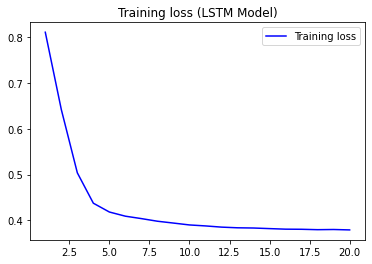

In [174]:
# Create an LSTM neural network
model = create_LSTM(hidden_units=3, dense_units=1, input_shape=(lag, Xtrain.shape[-1]),
                    activation=['tanh', 'linear'])
history = model.fit(Xtrain, Ytrain, epochs=20, batch_size=1, verbose=2)
plot_model(history, 'LSTM Model', 'lstm_model.png')

yhat_lstm = [x[0] for x in model.predict(Xval)]

train_predict = model.predict(Xtrain)
test_predict = model.predict(Xval)

# Print error
train_rmse, test_rmse = print_error(Ytrain, Yval, train_predict, test_predict)
rmse_table['model'].append('LSTM Neural Network')
rmse_table['training_rmse'].append(train_rmse)
rmse_table['testing_rmse'].append(test_rmse)


Epoch 1/20
440/440 - 4s - loss: 0.8315 - 4s/epoch - 10ms/step
Epoch 2/20
440/440 - 2s - loss: 0.6606 - 2s/epoch - 5ms/step
Epoch 3/20
440/440 - 2s - loss: 0.4982 - 2s/epoch - 4ms/step
Epoch 4/20
440/440 - 2s - loss: 0.4265 - 2s/epoch - 4ms/step
Epoch 5/20
440/440 - 2s - loss: 0.4086 - 2s/epoch - 4ms/step
Epoch 6/20
440/440 - 2s - loss: 0.4009 - 2s/epoch - 4ms/step
Epoch 7/20
440/440 - 2s - loss: 0.3958 - 2s/epoch - 4ms/step
Epoch 8/20
440/440 - 2s - loss: 0.3937 - 2s/epoch - 4ms/step
Epoch 9/20
440/440 - 2s - loss: 0.3911 - 2s/epoch - 4ms/step
Epoch 10/20
440/440 - 2s - loss: 0.3900 - 2s/epoch - 4ms/step
Epoch 11/20
440/440 - 2s - loss: 0.3882 - 2s/epoch - 5ms/step
Epoch 12/20
440/440 - 2s - loss: 0.3882 - 2s/epoch - 4ms/step
Epoch 13/20
440/440 - 2s - loss: 0.3859 - 2s/epoch - 4ms/step
Epoch 14/20
440/440 - 2s - loss: 0.3867 - 2s/epoch - 4ms/step
Epoch 15/20
440/440 - 2s - loss: 0.3853 - 2s/epoch - 5ms/step
Epoch 16/20
440/440 - 2s - loss: 0.3852 - 2s/epoch - 4ms/step
Epoch 17/20
440/

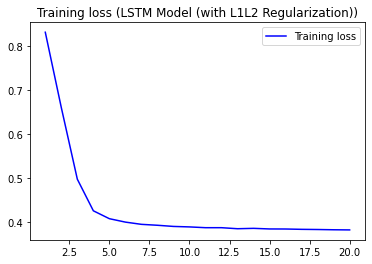

In [175]:
# Create an LSTM neural network with regularization
model = create_LSTM(hidden_units=3, dense_units=1, input_shape=(lag, Xtrain.shape[-1]),
                    activation=['tanh', 'linear'], kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4))
history = model.fit(Xtrain, Ytrain, epochs=20, batch_size=1, verbose=2)
plot_model(history, 'LSTM Model (with L1L2 Regularization)',
           'lstm_reg_model.png')

yhat_lstm_reg = [x[0] for x in model.predict(Xval)]

train_predict = model.predict(Xtrain)
test_predict = model.predict(Xval)

# Print error
train_rmse, test_rmse = print_error(Ytrain, Yval, train_predict, test_predict)
rmse_table['model'].append('LSTM Neural Network (with L1L2 Regularization)')
rmse_table['training_rmse'].append(train_rmse)
rmse_table['testing_rmse'].append(test_rmse)


Pivoted                    temp                                      temp_absolute  \
type       gru_forecast lstm_forecast  original rnn_forecast  gru_forecast   
day                                                                          
2017-12-01          0.0     -0.074826  0.956305     0.201650     58.706843   
2018-01-01          0.0     -0.899851  0.283892    -0.750455     58.706843   
2018-02-01          0.0     -1.291507 -0.457486    -0.974672     58.706843   
2018-03-01          0.0     -1.299807 -0.966105    -0.983689     58.706843   
2018-04-01          0.0     -1.075106 -0.845416    -0.973942     58.706843   
2018-05-01          0.0     -0.679934 -1.043691    -0.910084     58.706843   
2018-06-01          0.0     -0.285309 -0.836795    -0.631326     58.706843   
2018-07-01          0.0      0.244992 -0.129900    -0.020445     58.706843   
2018-08-01          0.0      0.964465  0.370099     0.890199     58.706843   
2018-09-01          0.0      1.343865  1.094235     0.97

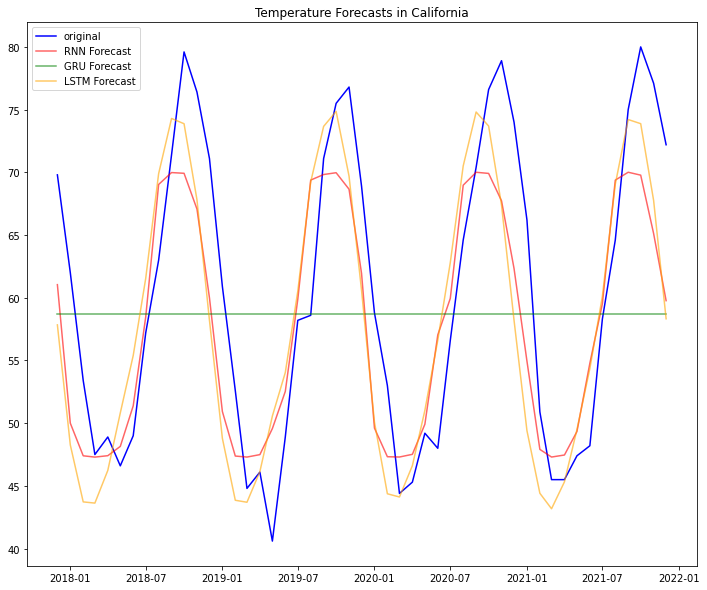

In [176]:
# Creating the frame to store both predictions
days = temp_CA['Date'].values[-len(y):]
frame = pd.concat([
    pd.DataFrame({'day': days, 'temp': y, 'type': 'original'}),
    pd.DataFrame({'day': days, 'temp': yhat_d, 'type': 'rnn_forecast'}),
    pd.DataFrame({'day': days, 'temp': yhat_gru, 'type': 'gru_forecast'}),
    pd.DataFrame({'day': days, 'temp': yhat_lstm, 'type': 'lstm_forecast'})
])
# Creating the unscaled values column
frame['temp_absolute'] = [(x * train_std) + train_mean for x in frame['temp']]
# Pivoting
pivoted = frame.pivot_table(index='day', columns='type')
print('Pivoted', pivoted)
pivoted.columns = ['_'.join(x).strip() for x in pivoted.columns.values]

plt.figure(figsize=(12, 10))
plt.plot(pivoted.index, pivoted.temp_absolute_original,
         color='blue', label='original')
plt.plot(pivoted.index, pivoted.temp_absolute_rnn_forecast,
         color='red', label='RNN Forecast', alpha=0.5)
plt.plot(pivoted.index, pivoted.temp_absolute_gru_forecast,
         color='green', label='GRU Forecast', alpha=0.5)
plt.plot(pivoted.index, pivoted.temp_absolute_lstm_forecast,
         color='orange', label='LSTM Forecast', alpha=0.5)
plt.title('Temperature Forecasts in California')
plt.legend()
plt.savefig('./graph/deep_CA/nn_forecasts.png')

Pivoted                    temp                                      temp_absolute  \
type       gru_forecast lstm_forecast  original rnn_forecast  gru_forecast   
day                                                                          
2017-12-01     0.102888      0.155600  0.956305     0.363963     59.900342   
2018-01-01     0.000000     -0.820553  0.283892    -0.546648     58.706843   
2018-02-01     0.000000     -1.206382 -0.457486    -0.956933     58.706843   
2018-03-01     0.000000     -1.224549 -0.966105    -0.985582     58.706843   
2018-04-01     0.000000     -1.033316 -0.845416    -0.973617     58.706843   
2018-05-01     0.000000     -0.673578 -1.043691    -0.820158     58.706843   
2018-06-01     0.000000     -0.331485 -0.836795    -0.430913     58.706843   
2018-07-01     0.293591      0.198358 -0.129900     0.191517     62.112507   
2018-08-01     1.012327      1.037482  0.370099     0.815664     70.449863   
2018-09-01     1.397452      1.346988  1.094235     0.96

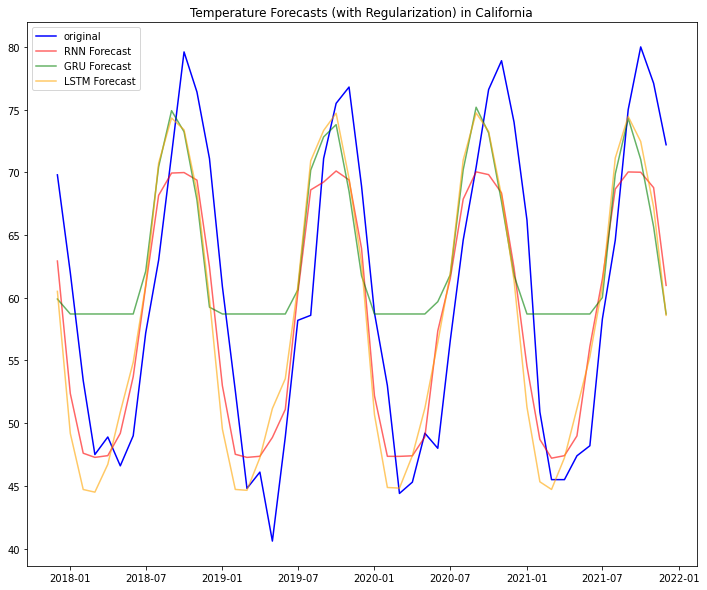

In [177]:
# Creating the frame to store both predictions
days = temp_CA['Date'].values[-len(y):]
frame = pd.concat([
    pd.DataFrame({'day': days, 'temp': y, 'type': 'original'}),
    pd.DataFrame({'day': days, 'temp': yhat_d_reg, 'type': 'rnn_forecast'}),
    pd.DataFrame({'day': days, 'temp': yhat_gru_reg, 'type': 'gru_forecast'}),
    pd.DataFrame({'day': days, 'temp': yhat_lstm_reg, 'type': 'lstm_forecast'})
])
# Creating the unscaled values column
frame['temp_absolute'] = [(x * train_std) + train_mean for x in frame['temp']]
# Pivoting
pivoted = frame.pivot_table(index='day', columns='type')
print('Pivoted', pivoted)
pivoted.columns = ['_'.join(x).strip() for x in pivoted.columns.values]

plt.figure(figsize=(12, 10))
plt.plot(pivoted.index, pivoted.temp_absolute_original,
         color='blue', label='original')
plt.plot(pivoted.index, pivoted.temp_absolute_rnn_forecast,
         color='red', label='RNN Forecast', alpha=0.5)
plt.plot(pivoted.index, pivoted.temp_absolute_gru_forecast,
         color='green', label='GRU Forecast', alpha=0.5)
plt.plot(pivoted.index, pivoted.temp_absolute_lstm_forecast,
         color='orange', label='LSTM Forecast', alpha=0.5)
plt.title('Temperature Forecasts (with Regularization) in California')
plt.legend()
plt.savefig('./graph/deep_CA/nn_reg_forecasts.png')

In [179]:
rmse_df = pd.DataFrame(rmse_table)
print(rmse_df)
rmse_df.to_csv('./data/rmseCA.csv', index=False)

                                               model  training_rmse  \
0                           Recurrent Neural Network       0.573164   
1  Recurrent Neural Network (with L1L2 Regulariza...       0.529085   
2                                 GRU Neural Network       1.003294   
3      GRU Neural Network (with L1L2 Regularization)       0.808485   
4                                LSTM Neural Network       0.619229   
5     LSTM Neural Network (with L1L2 Regularization)       0.571462   

   testing_rmse  
0      0.590040  
1      0.538552  
2      1.040128  
3      0.795620  
4      0.660353  
5      0.625570  
